Adversarial ALSTM as described in "Enhancing Stock Movement Prediction with Adversarial Training".

Using eager execution for the experimental component/toy example, then moving to a computational graph once refined.

In [ ]:
# Libraries

import argparse
import copy
import numpy as np
import os
import random
from sklearn.utils import shuffle
import tensorflow as tf
from time import time

try:
    from tensorflow.python.ops.nn_ops import leaky_relu
except ImportError:
    from tensorflow.python.framework import ops
    from tensorflow.python.ops import math_ops

    # Custom leaky ReLU to
    def leaky_relu(features, alpha=0.2, name=None):
        with ops.name_scope(name, "LeakyRelu", [features, alpha]):
            features = ops.convert_to_tensor(features, name="features")
            alpha = ops.convert_to_tensor(alpha, name="alpha")
            return math_ops.maximum(alpha * features, features)

# Load data

from datetime import datetime
import numpy as np
import os

In [ ]:
def load_data_temp(data_path, tra_date, val_date, tes_date,
                   seq=2, date_format='%Y-%m-%d'):
  fnames = [f for f in os.listdir(data_path)
            if os.path.isfile(os.path.join(data_path, f))]
  print(fnames)

  data_EOD = []

  # Obtain all those fnames
  for index, fname in enumerate(fnames):
    #print(fname)
    single_EOD = np.genfromtxt(
        os.path.join(data_path, fname), dtype=float, delimiter=',',
        skip_header=False
    )
    #print('data shape:', single_EOD.shape)
    data_EOD.append(single_EOD)
  fea_dim = data_EOD[0].shape[1] - 2
  #print(fea_dim)
  print(data_EOD[0][0])

  trading_dates = np.genfromtxt(
    'trading_dates.csv', dtype=str,
    delimiter=',', skip_header=False
  )

  print(trading_dates)

  # One-hot encode the weekdays of training dates
  dates_index = {}
  data_wd = np.zeros([len(trading_dates), 5], dtype=float)
  wd_encodings = np.identity(5, dtype=float)
  for index, date in enumerate(trading_dates):
      dates_index[date] = index
      # indices_weekday[index] = datetime.strptime(date, date_format).weekday()
      data_wd[index] = wd_encodings[datetime.strptime(date, date_format).weekday()]
  #print(data_wd)

  tra_ind = dates_index[tra_date]
  val_ind = dates_index[val_date]
  tes_ind = dates_index[tes_date]
  print(tra_ind, val_ind, tes_ind)

  tra_ind = dates_index[tra_date]
  val_ind = dates_index[val_date]
  tes_ind = dates_index[tes_date]
  print(tra_ind, val_ind, tes_ind)

  # count training, validation, and testing instances
  tra_num = 0
  val_num = 0
  tes_num = 0

  print(data_EOD[0].shape)
  print(data_EOD[1].shape)
  print(data_EOD[2].shape)
  print(data_EOD[3].shape)
  print(data_EOD[4].shape)

  # training
  for date_ind in range(tra_ind, val_ind):
    # filter out instances without length enough history
    if date_ind < seq:
      continue
    for tic_ind in range(len(fnames)):
      if abs(data_EOD[tic_ind][date_ind][-2]) > 1e-8:
        if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
          tra_num += 1
  print(tra_num, ' training instances')

  # validation
  for date_ind in range(val_ind, tes_ind):
    # filter out instances without length enough history
    if date_ind < seq:
      continue
    for tic_ind in range(len(fnames)):
      if abs(data_EOD[tic_ind][date_ind][-2]) > 1e-8:
        if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
          val_num += 1
  print(val_num, ' validation instances')

  # testing
  for date_ind in range(tes_ind, len(trading_dates)):
    # filter out instances without length enough history
    if date_ind < seq:
      continue
    for tic_ind in range(len(fnames)):
      if abs(data_EOD[tic_ind][date_ind][-2]) > 1e-8:
        if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
          tes_num += 1
  print(tes_num, ' testing instances')

  # generate training, validation, and testing instances
  # training
  tra_pv = np.zeros([tra_num, seq, fea_dim], dtype=float)
  tra_wd = np.zeros([tra_num, seq, 5], dtype=float)
  tra_gt = np.zeros([tra_num, 1], dtype=float)
  ins_ind = 0
  for date_ind in range(tra_ind, val_ind):
    # filter out instances without length enough history
    if date_ind < seq:
      continue
    for tic_ind in range(len(fnames)):
        if abs(data_EOD[tic_ind][date_ind][-2]) > 1e-8 and \
                data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
          tra_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, : -2]
          tra_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
          tra_gt[ins_ind, 0] = (data_EOD[tic_ind][date_ind][-2] + 1) / 2
          ins_ind += 1

  # validation
  val_pv = np.zeros([val_num, seq, fea_dim], dtype=float)
  val_wd = np.zeros([val_num, seq, 5], dtype=float)
  val_gt = np.zeros([val_num, 1], dtype=float)
  ins_ind = 0
  for date_ind in range(val_ind, tes_ind):
    # filter out instances without length enough history
    if date_ind < seq:
      continue
    for tic_ind in range(len(fnames)):
      if abs(data_EOD[tic_ind][date_ind][-2]) > 1e-8 and \
                      data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
        val_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, :-2]
        val_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
        val_gt[ins_ind, 0] = (data_EOD[tic_ind][date_ind][-2] + 1) / 2
        ins_ind += 1

  # testing
  tes_pv = np.zeros([tes_num, seq, fea_dim], dtype=float)
  tes_wd = np.zeros([tes_num, seq, 5], dtype=float)
  tes_gt = np.zeros([tes_num, 1], dtype=float)
  ins_ind = 0
  for date_ind in range(tes_ind, len(trading_dates)):
    # filter out instances without length enough history
    if date_ind < seq:
      continue
    for tic_ind in range(len(fnames)):
      if abs(data_EOD[tic_ind][date_ind][-2]) > 1e-8 and \
                        data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
        tes_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, :-2]
        # # for the momentum indicator
        # tes_pv[ins_ind, -1, -1] = data_EOD[tic_ind][date_ind - 1, -1] - data_EOD[tic_ind][date_ind - 11, -1]
        tes_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
        tes_gt[ins_ind, 0] = (data_EOD[tic_ind][date_ind][-2] + 1) / 2
        ins_ind += 1
  return tra_pv, tra_wd, tra_gt, val_pv, val_wd, val_gt, tes_pv, tes_wd, tes_gt

#print(things)

In [ ]:
# Retrieve information
# TODO: Move into class
tra_pv, tra_wd, tra_gt, val_pv, val_wd, val_gt, tes_pv, tes_wd, tes_gt = load_data_temp(
    data_path="tickers", tra_date='2014-01-02',
    val_date='2015-08-03', tes_date='2015-10-01')

['CMCSA.csv', 'BHP.csv', 'BA.csv', 'AAPL.csv', 'BAC.csv', 'BRK-B.csv', 'D.csv', 'CVX.csv', 'CHL.csv', 'DCM.csv', 'AMZN.csv']
[-123321. -123321. -123321. -123321. -123321. -123321. -123321. -123321.
 -123321. -123321. -123321. -123321. -123321.]
['2007-01-03' '2007-01-04' '2007-01-05' ... '2016-12-28' '2016-12-29'
 '2016-12-30']
1762 2160 2202
1762 2160 2202
(2518, 13)
(2518, 13)
(2518, 13)
(2518, 13)
(2518, 13)
2704  training instances
332  validation instances
2268  testing instances


In [ ]:
print("Training", tra_pv[0:3], tra_wd[0:3], tra_gt[0:3])
print("Validation", val_pv[0:3], val_wd[0:3], val_gt[0:3])
print("Test", tes_pv[0:3], tes_wd[0:3], tes_gt[0:3])

Training [[[-0.597644  0.289186 -0.616927  0.154466  0.532993 -1.034899 -2.447728
   -3.611381 -4.169199 -4.216563 -5.015754]
  [-0.173177  0.230901 -0.500292  0.192794  0.192793 -0.774305 -2.074462
   -3.410089 -4.061608 -4.19795  -4.915045]]

 [[-0.38388   0.310053 -0.472463  0.474706  0.474706 -0.992179 -2.709292
   -2.941095 -2.500373 -1.769973 -0.77514 ]
  [-1.070375  0.       -1.070375  0.693923  0.693923 -1.12023  -2.793252
   -3.525901 -3.077709 -2.496183 -1.613876]]

 [[ 0.530196  1.004474 -0.396739 -0.994484 -0.994484  1.575057  0.501517
    0.763665  0.914216  0.055978 -0.995033]
  [-1.220987  0.04634  -1.251288  1.172188  1.172188  0.074862 -0.600158
   -0.468077 -0.167731 -0.809384 -1.928037]]] [[[1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] [[0.]
 [0.]
 [0.]]
Validation [[[ 0.064145  0.465043 -0.529189 -0.19206  -0.19206  -0.407313  1.084026
    1.409021  0.965361  0.273353 -0.30442 ]
  [ 0.608878  0.

In [ ]:
device_name = '/gpu:0'
tf.random.set_seed(20241029)
print('device name:', device_name)

device name: /gpu:0


In [ ]:
# Default params:
seq = 5
steps = 1
batch_size = 1024
epoch = 150
learning_rate = 0.02
units = 32

# Loss functions
loss = 0
adv_loss = 0
l2_norm = 0

In [ ]:
# Really basic batching

batch_size = 32

def get_batch(sta_ind=None):
  if sta_ind is None:
      sta_ind = random.randrange(0, tra_pv.shape[0])
  if sta_ind + batch_size < tra_pv.shape[0]:
      end_ind = sta_ind + batch_size
  else:
      sta_ind = tra_pv.shape[0] - batch_size
      end_ind = tra_pv.shape[0]
  return tra_pv[sta_ind:end_ind, :, :], \
          tra_wd[sta_ind:end_ind, :, :], \
          tra_gt[sta_ind:end_ind, :]

In [ ]:
# Set up Input, LSTM

# NOTE: Initialzers set initial random weights

fea_dim = tra_pv.shape[2]
print(fea_dim)

gt_var = tf.constant([0,0], dtype=tf.float32)
pv = tf.random.normal([32, seq, ])
wd = tf.random.normal([32, seq, 5])

sample_input = tf.random.normal([32, seq, fea_dim])

dense_layer = tf.keras.layers.Dense(
    units=fea_dim,
    activation=tf.nn.tanh,
    kernel_initializer=tf.keras.initializers.glorot_uniform(),
    name = 'input_layer'
)

lstm_layer = tf.keras.layers.LSTM(
    units=units,  # Number of LSTM units
    return_sequences=True,      # Whether to return the full sequence of outputs
    name = 'lstm_layer'
)

in_lat = dense_layer(sample_input)
print(in_lat.shape)
# Pass the transformed input through the LSTM layer
outputs = lstm_layer(in_lat)
print(outputs.shape)

11
(32, 5, 11)
(32, 5, 32)


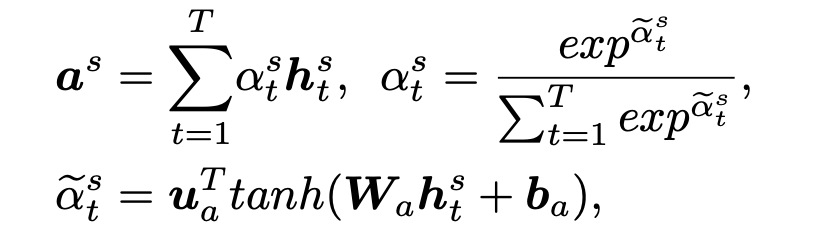

In [ ]:
# Retrieve Latent representation
att_W = tf.Variable(
    tf.random.uniform([units, units], dtype=tf.float32),
    name='att_W'
)
att_b = tf.Variable(
    tf.zeros([units], dtype=tf.float32),
    name='att_b'
)
att_u = tf.Variable(
    tf.random.uniform([units], dtype=tf.float32),
    name='att_u'
)

a_laten = tf.tanh(tf.tensordot(outputs, att_W, axes=1) + att_b)

# Compute attention scores
# ua (dot) tanh(Waht + ba)
a_scores = tf.tensordot(a_laten, att_u, axes=1)

# Apply softmax to get attention weights
a_alphas = tf.nn.softmax(a_scores, axis=1)

# Weighted sum of outputs with attention weights
# a^s = sum_{i=1}^T a_alphas * outputs
a_con = tf.reduce_sum(outputs * tf.expand_dims(a_alphas, -1), axis=1)

fea_con = tf.concat([outputs[:, -1, :], a_con],axis=1)

print(fea_con)

tf.Tensor(
[[-0.01702776  0.09934065  0.07856461 ...  0.01941139 -0.01365364
   0.01684877]
 [-0.00433053 -0.03607856 -0.00824117 ... -0.04701608 -0.00229451
   0.0724311 ]
 [ 0.09101734 -0.08447144  0.10019642 ...  0.00806728  0.09209251
  -0.03118846]
 ...
 [-0.04617798 -0.03367228  0.11707288 ...  0.06594326  0.13755818
   0.00351808]
 [ 0.00153669 -0.13668238 -0.06497682 ...  0.02003976  0.08278851
   0.02420886]
 [-0.00883268 -0.04638832 -0.08593844 ...  0.02788088  0.12517956
  -0.08268254]], shape=(32, 64), dtype=float32)


In [ ]:
# Final temporary prediction
predictive_fc = tf.keras.layers.Dense(
    units=1,
    kernel_initializer=tf.keras.initializers.GlorotUniform(),
    name='predictive_fc'
)

# Predictive layer to compute confidence score y_hat_s
y_hat_s = predictive_fc(fea_con)  # Shape: [batch_size, 1]

# Final prediction: sign of y_hat_s
y_pred = tf.sign(y_hat_s)  # Shape: [batch_size, 1]
print(y_pred)

tf.Tensor(
[[ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]], shape=(32, 1), dtype=float32)


In [ ]:
batch_num = len(tra_gt) // batch_size
batch_num += 1 if len(tra_gt) % batch_size != 0 else 0
print(batch_num)

# for i in range(batch_num):
  # Do the above
  #predictive_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

84.5
